In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from datetime import datetime
import csv
import pickle
from joblib import dump, load

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV

In [2]:
FOLDER_PATH = "F:\\user\\Google Drive\\Catherning Folder\\THU\\Thesis\\Work\\Recipe datasets\\cuisine_classification"

FILES = ["random","cluster_centroid","full"]
file = FILES[2]

In [3]:
date = datetime.now().strftime("%m-%d-%H-%M")
RESULTS_FOLDER = os.path.join(os.getcwd(),"results",f"ML_{date}_{file}")
if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

In [4]:
results_file = os.path.join(RESULTS_FOLDER,"results.csv")
with open(results_file,"w", newline='') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(["model","best parameters","best f1 train score","threshold","proba score","accuracy","balanced_accuracy","precision","recall","f1_score"])

In [5]:
df_train = pd.read_pickle(os.path.join(FOLDER_PATH, file+"_data.pkl"))

In [6]:
df_train['cuisine'].value_counts()

NorthAmerican       54022
SouthernEuropean     8963
LatinAmerican        6347
WesternEuropean      4243
Asian                3144
EastAsian            2788
SouthAsian           2078
SoutheastAsian        805
MiddleEastern         645
EasternEuropean       381
African               363
NorthernEuropean      250
Name: cuisine, dtype: int64

In [7]:
len(df_train)

84029

In [8]:
cv = CountVectorizer()
X = cv.fit_transform(df_train['all_ingredients'].values)

In [9]:
df_train['all_ingredients'].values

array(['baby_bella_mushroom_sliced;arborio_rice;olive_oil;butter;shallot_minced;white_wine;fat_free_chicken_stock_;salt_pepper;salt_pepper;grated_parmesan_cheese;chopped_parsley',
       'garlic;extra-virgin_olive_oil_divided;madeira_divided;unsalted_chicken_stock_divided;dried_porcini_mushroom_;chopped_onion;thinly_sliced_cremini_mushroom_;thinly_sliced_shiitake_mushroom_cap_;uncooked_arborio_rice;parmesan_cheese_grated_;kosher_salt;freshly_ground_black_pepper;chopped_fresh_sage;sage_',
       'garlic_halved;cooking_spray;peeled_red_potato_;butter_melted;salt;black_pepper;shredded_gruyere_cheese;fat-free_milk',
       ..., 'vegetable;olive_oil;egg;cheese;wheat',
       'tomato;clam;celery;black_pepper;parsley;macaroni',
       'milk;bacon;egg;cream;cheese;onion;black_pepper;parsley;macaroni'],
      dtype=object)

In [10]:
dump(cv.vocabulary_,"scikit_vocab.joblib")

['scikit_vocab.joblib']

## Processing

In [11]:
enc = LabelEncoder()
y = enc.fit_transform(df_train.cuisine)
print(enc.classes_)
enc.classes_.shape

['African' 'Asian' 'EastAsian' 'EasternEuropean' 'LatinAmerican'
 'MiddleEastern' 'NorthAmerican' 'NorthernEuropean' 'SouthAsian'
 'SoutheastAsian' 'SouthernEuropean' 'WesternEuropean']


(12,)

In [12]:
dump(enc,"scikit_vocab_cuisine.joblib")

['scikit_vocab_cuisine.joblib']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 72,
 1: 629,
 2: 558,
 3: 76,
 4: 1269,
 5: 129,
 6: 10804,
 7: 50,
 8: 416,
 9: 161,
 10: 1793,
 11: 849}

## Results methods

In [15]:
# For future predictions, get proba and only classifies if proba is higher than threshold
def threshold_classification(clf,X_test,y_test,threshold=0.85):
    y_pred_prob = clf.predict_proba(X_test)
    max_prob = y_pred_prob.max(axis=1)
    y_pred = y_pred_prob.argmax(axis=1)

    to_del = np.argwhere(max_prob < threshold).T[0]

    partial_y_pred = np.delete(y_pred,to_del)
    partial_y_test = np.delete(y_test,to_del)

    proba_score = accuracy_score(partial_y_test,partial_y_pred)
    
    return proba_score

In [16]:
def confusion_matrix_plot(y_pred,y_labels,save_path,name):
    fig = plt.figure(figsize=(10, 10))

    cm = confusion_matrix(y_labels, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm_normalized, interpolation='nearest')
    plt.title(name+" Confusion matrix")
    plt.colorbar(shrink=0.3)
    cuisines = df_train['cuisine'].value_counts().index
    tick_marks = np.arange(len(cuisines))
    plt.xticks(tick_marks, enc.classes_, rotation=90)
    plt.yticks(tick_marks, enc.classes_)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.show()
    
    fig.savefig(save_path, dpi=fig.dpi)

In [17]:
def classification_report_to_csv(y_test,y_pred,enc,model_type,RESULTS_FOLDER):
    report = classification_report(y_test, y_pred, labels=[i for i in range(enc.classes_.shape[0])], target_names=enc.classes_, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(os.path.join(RESULTS_FOLDER,f'{model_type}.csv'))

# Logistic Regression

In [18]:
#parameters = {'C':[0.4,0.5,0.6,0.7],
#             'solver' : ('newton-cg', 'liblinear')}
parameters = {'C':[0.7],
              'solver' : ('liblinear',)}
# sorted(sklearn.metrics.SCORERS.keys())
scoring = 'f1_weighted'
logistic = LogisticRegression(class_weight="balanced",multi_class="auto",max_iter=150,warm_start=True)

try:
    clf = load("log_reg.joblib")
except FileNotFoundError:
    clf = GridSearchCV(logistic, parameters, cv=4,scoring=scoring)
    
clf.fit(X_train, y_train)
dump(clf,"log_reg.joblib")

['log_reg.joblib']

## Results

In [19]:
print(clf.best_estimator_)
clf.best_score_

LogisticRegression(C=0.7, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=150, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=True)


0.7399509443847415

In [20]:
test_score = clf.best_estimator_.score(X_test, y_test)
test_score

0.726526240628347

In [21]:
threshold = 0.95
proba_score = threshold_classification(clf,X_test,y_test,threshold=threshold)
proba_score

0.9764150943396226

C:\Users\TEMP.PKAPRIME.000.001\AppData\Local\conda\conda\envs\recipe_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


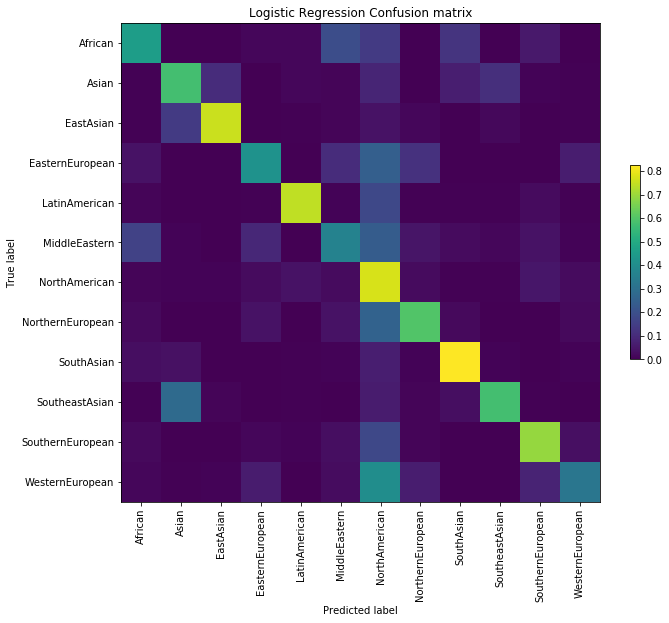

In [38]:
y_pred = clf.best_estimator_.predict(X_test)
confusion_matrix_plot(y_pred, y_test,os.path.join(RESULTS_FOLDER,'logistic_regression.png'),"Logistic Regression")

In [39]:
classification_report_to_csv(y_test,y_pred,enc,"logistic_regression",RESULTS_FOLDER)    

In [42]:
res=[accuracy_score(y_test,y_pred),balanced_accuracy_score(y_test,y_pred),precision_score(y_test,y_pred,average='weighted'),recall_score(y_test,y_pred,average='weighted'),f1_score(y_test,y_pred,average='weighted')]
res

[0.726526240628347,
 0.5936989618606122,
 0.781694937899619,
 0.726526240628347,
 0.748612898833331]

In [43]:
recall_score(y_test,y_pred,average='weighted')

0.726526240628347

In [44]:
recall_score(y_test,y_pred,average='micro')

0.726526240628347

In [45]:
recall_score(y_test,y_pred,average='macro')

0.5936989618606122

In [25]:
with open(results_file,"a", newline='') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(["logistic regression",clf.best_estimator_,clf.best_score_,threshold,proba_score]+res)

# SVM

In [26]:
parameters = {'loss':("log",)}#('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron')}
# sorted(sklearn.metrics.SCORERS.keys())
scoring = 'f1_weighted'
sgd = SGDClassifier(class_weight="balanced",early_stopping=True,warm_start=True)

try:
    clf3 = load("svm.joblib")
except FileNotFoundError:
    clf3 = GridSearchCV(sgd, parameters, cv=4,scoring=scoring)
    
clf3.fit(X_train, y_train)
dump(clf3,"svm.joblib")

GridSearchCV(cv=4, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight='balanced',
                                     early_stopping=True, epsilon=0.1, eta0=0.0,
                                     fit_intercept=True, l1_ratio=0.15,
                                     learning_rate='optimal', loss='hinge',
                                     max_iter=1000, n_iter_no_change=5,
                                     n_jobs=None, penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=True),
             iid='deprecated', n_jobs=None, param_grid={'loss': ('log',)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [27]:
print(clf3.best_estimator_)
clf3.best_score_

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=True)


0.7199565146199435

In [28]:
clf3.best_estimator_.score(X_test, y_test)

0.700226109722718

In [29]:
proba_score = threshold_classification(clf3,X_test,y_test,threshold=threshold)
proba_score

0.9604863221884499

C:\Users\TEMP.PKAPRIME.000.001\AppData\Local\conda\conda\envs\recipe_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


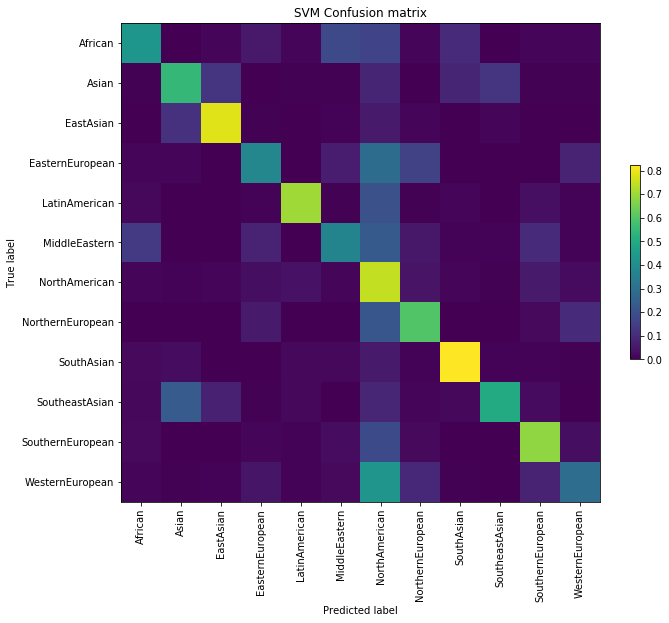

In [30]:
y_pred = clf3.predict(X_test)
confusion_matrix_plot(y_pred, y_test,os.path.join(RESULTS_FOLDER,'svm.png'),"SVM")

In [31]:
classification_report_to_csv(y_test,y_pred,enc,"svm",RESULTS_FOLDER)    

In [32]:
res=[accuracy_score(y_test,y_pred),balanced_accuracy_score(y_test,y_pred),precision_score(y_test,y_pred,average='weighted'),recall_score(y_test,y_pred,average='weighted'),f1_score(y_test,y_pred,average='weighted')]

with open(results_file,"a", newline='') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(["svm",clf3.best_estimator_,clf3.best_score_,threshold,proba_score]+res)
    
print(res)

[0.700226109722718, 0.5722461710055593, 0.7649626896792315, 0.700226109722718, 0.7258601460242251]


# Naive Bayes

In [33]:
parameters = {'alpha':[0.2,]}#[i*0.2 for i in range(1,5)]}
# sorted(sklearn.metrics.SCORERS.keys())
scoring = 'f1_weighted'
bayes = ComplementNB()

try:
    clf4 = load("naive_bayes.joblib")
except FileNotFoundError:
    clf4 = GridSearchCV(bayes, parameters, cv=4,scoring=scoring)
    
clf4.fit(X_train, y_train)
dump(clf4,"naive_bayes.joblib")

GridSearchCV(cv=4, error_score=nan,
             estimator=ComplementNB(alpha=1.0, class_prior=None, fit_prior=True,
                                    norm=False),
             iid='deprecated', n_jobs=None, param_grid={'alpha': [0.2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [34]:
clf4.best_score_

0.7111651066607004

In [35]:
clf4.score(X_test,y_test)

0.7138163872647016

In [36]:
proba_score = threshold_classification(clf4,X_test,y_test,threshold=threshold)
proba_score

0.9120559114735003

C:\Users\TEMP.PKAPRIME.000.001\AppData\Local\conda\conda\envs\recipe_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


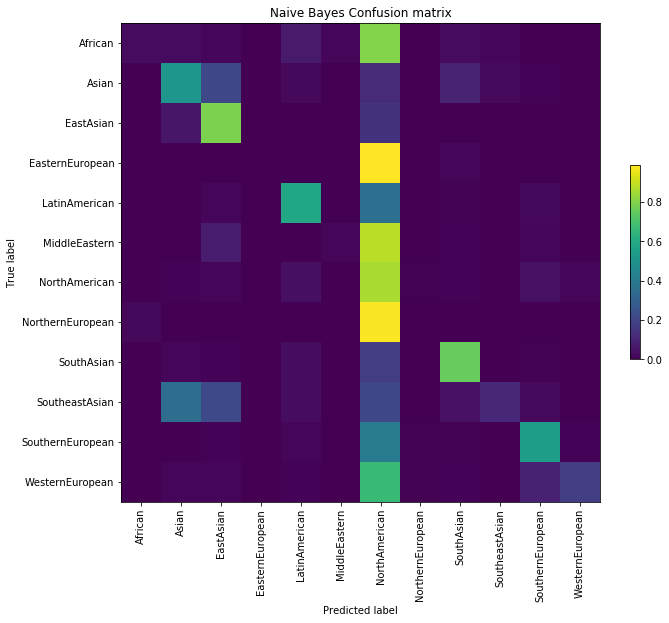

In [37]:
y_pred = clf4.predict(X_test)
confusion_matrix_plot(y_pred, y_test,os.path.join(RESULTS_FOLDER,'naive_bayes.png'),"Naive Bayes")

In [38]:
classification_report_to_csv(y_test,y_pred,enc,"naive bayes",RESULTS_FOLDER)    

In [39]:
res=[accuracy_score(y_test,y_pred),balanced_accuracy_score(y_test,y_pred),precision_score(y_test,y_pred,average='weighted'),recall_score(y_test,y_pred,average='weighted'),f1_score(y_test,y_pred,average='weighted')]

with open(results_file,"a", newline='') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(["naive bayes",clf4.best_estimator_,clf4.best_score_,threshold,proba_score]+res)
    
print(res)

[0.7307509222896584, 0.36685076975293174, 0.7104783245996749, 0.7307509222896584, 0.7138163872647016]


# Decision Tree 

In [40]:
parameters = {"criterion":["gini",],#"entropy"],
            "splitter":["best","random"]}
# sorted(sklearn.metrics.SCORERS.keys())
scoring = 'f1_weighted'
dec_tree = DecisionTreeClassifier()

try:
    clf5 = load("decision_tree.joblib")
except FileNotFoundError:
    clf5 = GridSearchCV(dec_tree, parameters, cv=4,scoring=scoring)
    
clf5.fit(X_train, y_train)
dump(clf5,"decision_tree.joblib")
clf5.best_score_

0.6823130301251003

In [41]:
clf5.score(X_test,y_test)

0.6890330253395467

In [42]:
proba_score = threshold_classification(clf5,X_test,y_test,threshold=threshold)
proba_score

0.699042579994961

C:\Users\TEMP.PKAPRIME.000.001\AppData\Local\conda\conda\envs\recipe_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


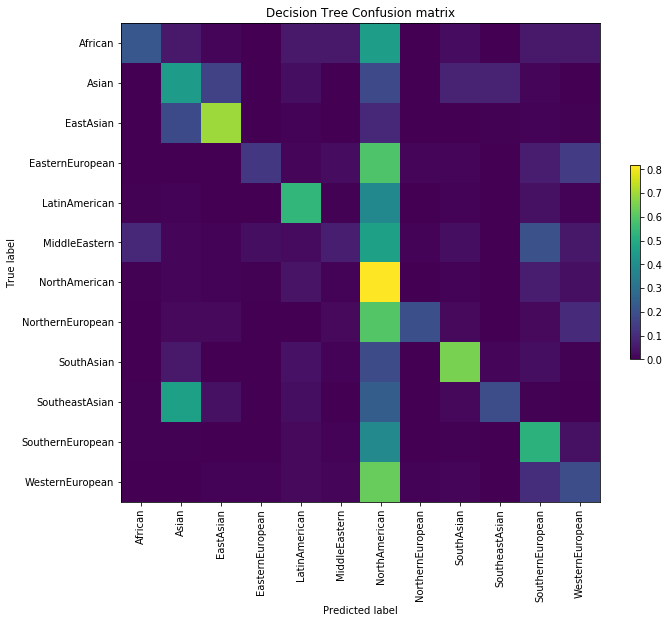

In [43]:
y_pred = clf5.predict(X_test)
confusion_matrix_plot(y_pred, y_test,os.path.join(RESULTS_FOLDER,'dec_tree.png'),"Decision Tree")

In [44]:
res=[accuracy_score(y_test,y_pred),balanced_accuracy_score(y_test,y_pred),precision_score(y_test,y_pred,average='weighted'),recall_score(y_test,y_pred,average='weighted'),f1_score(y_test,y_pred,average='weighted')]

with open(results_file,"a", newline='') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(["dec_tree",clf5.best_estimator_,clf5.best_score_,threshold,proba_score]+res)
    
print(res)

[0.6930263001309056, 0.39138385720532054, 0.6858026048222883, 0.6930263001309056, 0.6890330253395467]


In [45]:
classification_report_to_csv(y_test,y_pred,enc,"dec_tree",RESULTS_FOLDER)    

# Extra Tree 

In [26]:
parameters = {"criterion":["gini",]}#"entropy"]}
# sorted(sklearn.metrics.SCORERS.keys())
scoring = 'f1_weighted'
extra_tree = ExtraTreesClassifier()

try:
    clf6 = load("extra_tree.joblib")
except FileNotFoundError:
    clf6 = GridSearchCV(extra_tree, parameters, cv=4,scoring=scoring)
    clf6.fit(X_train, y_train)
    dump(clf6,"extra_tree.joblib")
    
clf6.best_score_

0.7316658610729341

In [27]:
clf6.score(X_test,y_test)

0.7386661641458815

In [28]:
proba_score = threshold_classification(clf6,X_test,y_test,threshold=threshold)
proba_score

0.8632007666506948

C:\Users\TEMP.PKAPRIME.000.001\AppData\Local\conda\conda\envs\recipe_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


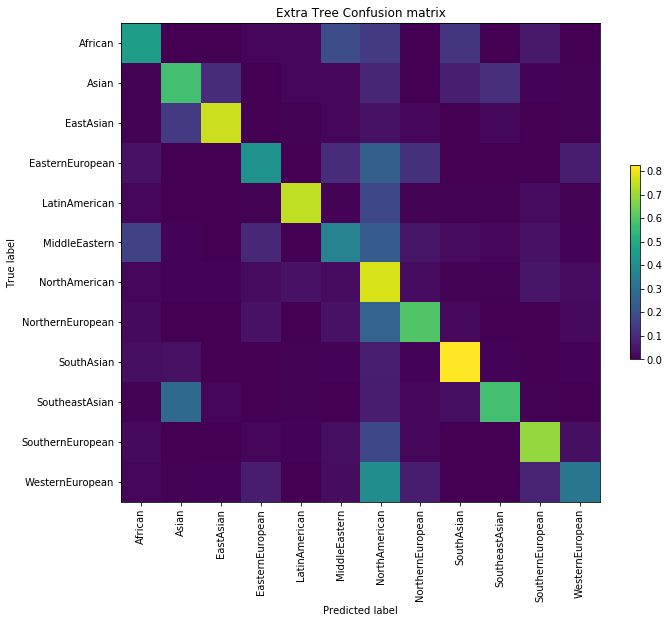

In [33]:
y_pred = clf.predict(X_test)
confusion_matrix_plot(y_pred, y_test,os.path.join(RESULTS_FOLDER,'extra_tree.png'),"Extra Tree")

In [34]:
res=[accuracy_score(y_test,y_pred),balanced_accuracy_score(y_test,y_pred),precision_score(y_test,y_pred,average='weighted'),recall_score(y_test,y_pred,average='weighted'),f1_score(y_test,y_pred,average='weighted')]

with open(results_file,"a", newline='') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(["extra_tree",clf6.best_estimator_,clf6.best_score_,threshold,proba_score]+res)
    
print(res)

[0.726526240628347, 0.5936989618606122, 0.781694937899619, 0.726526240628347, 0.748612898833331]


In [31]:
classification_report_to_csv(y_test,y_pred,enc,"extra_tree",RESULTS_FOLDER)    

## KNeighbors Classifier

In [52]:
parameters = {"n_neighbors":[3,],#i for i in range(3,7)],
            "weights":["distance",]}#"uniform","distance"]}
# sorted(sklearn.metrics.SCORERS.keys())
scoring = 'f1_weighted'
kneigh = KNeighborsClassifier()

try:
    clf7 = load("kneighbors.joblib")
except FileNotFoundError:
    clf7 = GridSearchCV(kneigh, parameters, cv=4,scoring=scoring)
    
clf7.fit(X_train, y_train)
dump(clf7,"kneighbors.joblib")
clf7.best_score_

0.631979660834786

In [53]:
clf7.score(X_test,y_test)

0.6351853483822475

In [54]:
proba_score = threshold_classification(clf7,X_test,y_test,threshold=threshold)
proba_score

0.8056851470109581

C:\Users\TEMP.PKAPRIME.000.001\AppData\Local\conda\conda\envs\recipe_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


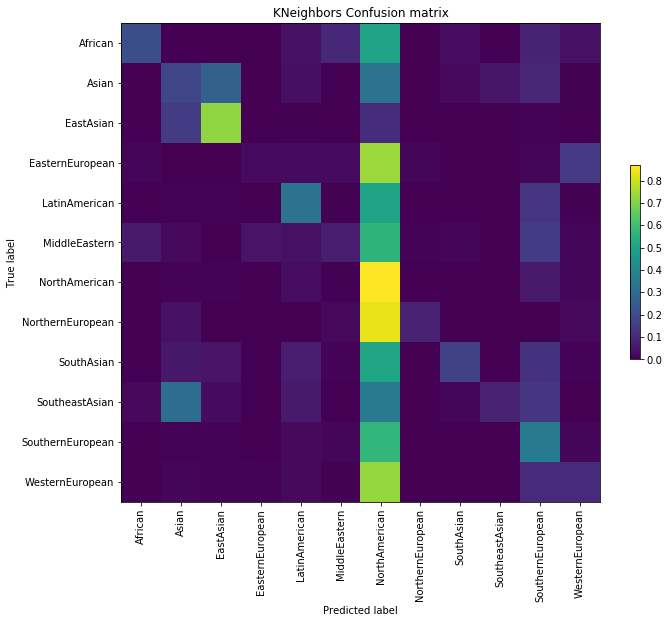

In [55]:
y_pred = clf7.predict(X_test)
confusion_matrix_plot(y_pred, y_test,os.path.join(RESULTS_FOLDER,'KNeighbors.png'),"KNeighbors")

In [56]:
res=[accuracy_score(y_test,y_pred),balanced_accuracy_score(y_test,y_pred),precision_score(y_test,y_pred,average='weighted'),recall_score(y_test,y_pred,average='weighted'),f1_score(y_test,y_pred,average='weighted')]

with open(results_file,"a", newline='') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(["KNeighbors",clf7.best_estimator_,clf7.best_score_,threshold,proba_score]+res)
    
print(res)

[0.6640485540878258, 0.266708840518054, 0.6288976467768032, 0.6640485540878258, 0.6351853483822475]


In [57]:
classification_report_to_csv(y_test,y_pred,enc,"KNeighbors",RESULTS_FOLDER)    

## Linear SVC

In [58]:
parameters = {"penalty":["l2",],#"l1"],
             "dual":[False,True],
             "C":[1]}#i for i in range(1,5)]}
# sorted(sklearn.metrics.SCORERS.keys())
scoring = 'f1_weighted'
svc = LinearSVC()

try:
    clf8 = load("kneighbors.joblib")
except FileNotFoundError:
    clf8 = CalibratedClassifierCV(svc,method="sigmoid",cv=4)
    
clf8.fit(X_train, y_train)
dump(clf7,"kneighbors.joblib")

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None,
                                                dual=True, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=None, tol=0.0001,
                                                verbose=0),
                       cv=4, method='sigmoid')

In [66]:
best_score = clf8.score(X_train,y_train)
best_score

0.8498430596670782

In [59]:
clf8.score(X_test,y_test)

0.779543020349875

In [60]:
proba_score = threshold_classification(clf8,X_test,y_test,threshold=threshold)
proba_score

0.9719626168224299

C:\Users\TEMP.PKAPRIME.000.001\AppData\Local\conda\conda\envs\recipe_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


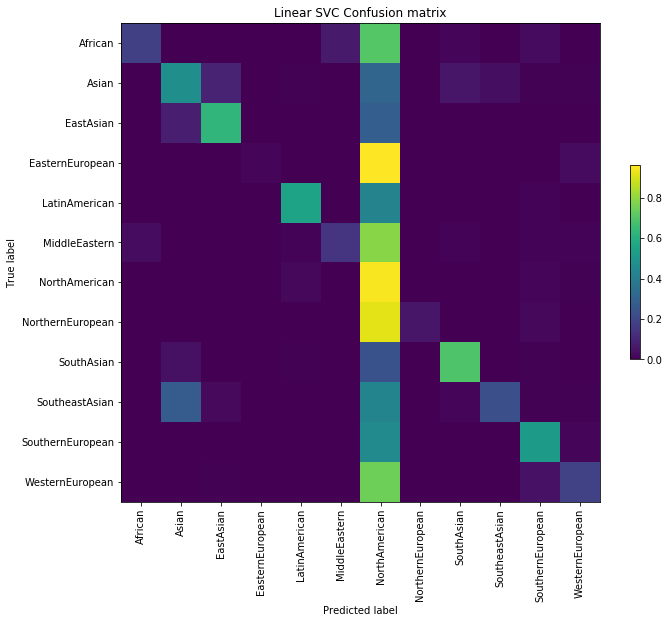

In [61]:
y_pred = clf8.predict(X_test)
confusion_matrix_plot(y_pred, y_test,os.path.join(RESULTS_FOLDER,'Linear SVC.png'),"Linear SVC")

In [65]:
clf8.calibrated_classifiers_[0]

In [68]:
res=[accuracy_score(y_test,y_pred),balanced_accuracy_score(y_test,y_pred),precision_score(y_test,y_pred,average='weighted'),recall_score(y_test,y_pred,average='weighted'),f1_score(y_test,y_pred,average='weighted')]

with open(results_file,"a", newline='') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(["Linear SVC",clf8.calibrated_classifiers_[0],best_score,threshold,proba_score]+res)
    
print(res)

[0.779543020349875, 0.3883882231940163, 0.7674266262319384, 0.779543020349875, 0.7535859026155998]


In [69]:
classification_report_to_csv(y_test,y_pred,enc,"Linear SVC",RESULTS_FOLDER)    

In [70]:
dump(clf8,"best_linearSVC.joblib")

['best_linearSVC.joblib']

# Random Forest

much slower and a bit worse

In [72]:
parameters = {'max_depth':(None,)}#3,5,8)}
# sorted(sklearn.metrics.SCORERS.keys())
scoring = 'f1_weighted'
rf = RandomForestClassifier(n_estimators=200, random_state=123,class_weight="balanced")

try:
    clf2 = load("random_forest.joblib")
except FileNotFoundError:
    clf2 = GridSearchCV(rf, parameters, cv=4,scoring=scoring)
    
clf2.fit(X_train, y_train)
dump(clf7,"random_forest.joblib")

GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=200, n_jobs=None,
                                              oob_score=False, random_state=123,
                           

In [73]:
print(clf2.best_estimator_)
clf2.best_score_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)


0.7005354998603699

In [74]:
clf2.best_estimator_.score(X_test, y_test)

0.743841485183863

In [75]:
proba_score = threshold_classification(clf2,X_test,y_test,threshold=threshold)
proba_score

0.9693877551020408

C:\Users\TEMP.PKAPRIME.000.001\AppData\Local\conda\conda\envs\recipe_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


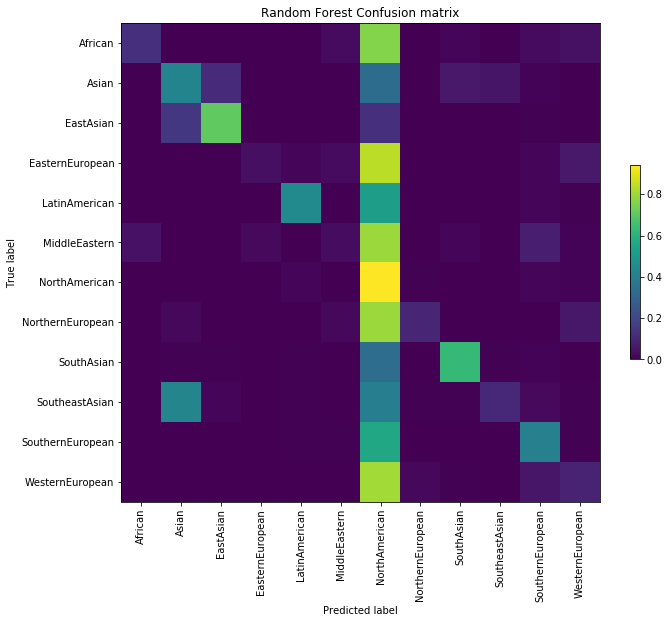

In [76]:
%matplotlib inline
y_pred = clf2.predict(X_test)
confusion_matrix_plot(y_pred, y_test,os.path.join(RESULTS_FOLDER,'random_forest.png'),"Random Forest")

In [77]:
res=[accuracy_score(y_test,y_pred),balanced_accuracy_score(y_test,y_pred),precision_score(y_test,y_pred,average='weighted'),recall_score(y_test,y_pred,average='weighted'),f1_score(y_test,y_pred,average='weighted')]

with open(results_file,"a", newline='') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(["random forest",clf2.best_estimator_,clf2.best_score_,threshold,proba_score]+res)
    
print(res)

[0.743841485183863, 0.3379043806341406, 0.716699944615536, 0.743841485183863, 0.7114454645890785]


In [78]:
classification_report_to_csv(y_test,y_pred,enc,"Random Forest",RESULTS_FOLDER)